##### Data Vizualization

In this notebook, we analyze the results obtained by our data corruption experiment over the following datasets:

1. [Linearly Separable](#syn-lin)
2. [Non-Linearly Separable](#syn-non)


  
We split the analysis of these datasets according to the above structure and create 3 plots:


|  Synthetic Separable | Synthetic Non-Separable | 
| :------------------: | :---------------------: | 
| [Plot Line](#syn-lin-plot) | [Plot Line](#syn-non-plot) |
| [Box Plot](#syn-lin-box)   | [Box Plot](#syn-non-box)   |
| [Table of Affordance](#syn-lin-table) | [Table of Affordance](#syn-non-table) |


In [249]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme(style='whitegrid')

%matplotlib notebook

In [310]:
def pocket_complexity(
    epsilon:      float, 
    epsilon_knot: float, 
    delta:        float, 
    p:            int,
    L:            float,
    ):
    """
    epsilon:      Actual Error of network
    epsilon_knot: Measured error on training set of E
    delta:        Probability
    p:            Number of input neurons
    L:            Length of the weight vector.
    """
    a = np.math.log(8/delta)
    s = (epsilon - epsilon_knot)/epsilon
    b_min = min(2*(p+1), 4*(p+1)*np.math.log10(np.math.e))
    c = max(a, b_min * np.math.log(16/(s**2 * epsilon)))
    A = np.math.ceil((8 / (s**2 * epsilon)) * c)
    
    x = (np.math.log(1/delta) + (p+1)*np.math.log(2*L+1)) / (s**2 * epsilon)
    B = x * min(1/(2*epsilon), 2)
    return np.math.ceil(min(A, B))

def epsilon_lower_bound(n_data, vc_dim, delta):
    """ Return epsilon for given sample size
    
    """
    return (1/n_data) * (vc_dim + np.math.log(1/delta))


def epsilon_PAC_complexity(
    total_data, 
    total_buckets, 
    vc_dim, 
    delta
    ):
    
    # To contain score per # of datapoints
    pac_analysis = {f'score': [], 'corruption': []}

    data_per_buckets = total_data / total_buckets
    # Dictionary of # of data for given # of buckets
    buckets_to_n_data = {buckets: data_per_buckets * buckets for buckets in range(1, total_buckets+1)}
    
    # Populate dictionary of values. Storing size S and obtained epsilon
    for buckets, data_points in buckets_to_n_data.items():
        epsilon_complexity       = 1 - epsilon_lower_bound(data_points, vc_dim, delta)
        pac_analysis[f'score'].append(epsilon_complexity)
        pac_analysis['corruption'].append(100 - buckets)
        
    return pd.DataFrame(pac_analysis)


def epsilon_pocket_complexity(
    total_data, 
    total_buckets, 
    epsilon_knot, 
    delta, 
    vc_dim, 
    L
    ):
    """"""
    # vc-dim - 1 == p
    
    # To contain score per # of datapoints
    pac_analysis = {f'score': [], 'corruption': []}
    
    # Will create dictionary of epsilon given some number of samples 
    epsilon_samples = np.linspace(0.05, 0.999999, 10_000_000) # Used in sampling for sample complexity.
    samples_to_epsilon = { pocket_complexity(epsilon=epsilon, epsilon_knot=epsilon_knot, delta=delta, p=vc_dim - 1, L=L): epsilon for epsilon in epsilon_samples }
    data_per_buckets = total_data // total_buckets
    # Dictionary of # of data for given # of buckets
    buckets_to_n_data = {buckets: data_per_buckets * buckets for buckets in range(1, total_buckets+1)}
    
    debug_counter = 0
    for buckets, n_data in buckets_to_n_data.items():
        debug_counter += 1
        try:
            epsilon_complexity = 1 - samples_to_epsilon[n_data]
        except KeyError:
            total_debug_counter = 0
            for buckets, n_data in buckets_to_n_data.items():
                total_debug_counter += 1
            #import pdb; pdb.set_trace()
            if n_data < 100:
                # Samples used too small. 
                epsilon_complexity = np.NaN
            else:
                # Sample asked for probably too large!
                epsilon_complexity = np.NaN
            
        pac_analysis[f'score'].append(epsilon_complexity)
        pac_analysis['corruption'].append(100 - buckets)
        
    return pd.DataFrame(pac_analysis)


In [3]:
from glob import glob
import re
from collections import defaultdict

def extract_and_combine(file: str, combine: bool=False):
    '''Collect and combine data
    
    params
    ======
    
    file:
        File name with wild (*) to search for.
    combine:
        Flag for whether returning combined dataframe of history.
    '''
    
    data = {} # Experiment -> results
    
    # Convert file wildcard into valid RegEx wildcard
    pattern = file.replace('*', '(.*)')

    # Collect every pickle file and load into data dictionary
    for f in glob(file):
        match = re.search(pattern, f)
        experiment = match.group(1).strip()
        with open(f, 'rb') as jar:
            data[experiment] = pickle.load(jar)
    
    # Combines the data into a singlue dictionary.
    if combine:
        combined_history =  defaultdict(list)
        for exp_num, _dict in data.items():
            for key, value in _dict['history'].items():
                combined_history[key].append(value[0])
            
        #history_frames = [pd.DataFrame(_dict['history']) for _dict in list(data.values())]
        return data, combined_history
    else:
        return data

### A Note on Seaborn Plotting

This is a personal note, and not required to be read if you understand seaborn (which I dont!)

#### Seaborn data plotting structure

Unlike Matplotlib, seaborn will only plot the data using the provided columns. In Matplotlib, it is possible to make plots just with a dictionary where the data can be categorized based on the columns. Further, we can use multiple datasets when passing them to matplotlib and perform the plotting. In seaborn, it seems like the data has to be all in one table/dictionary. Thus, to achieve a similar result as in matplotlib passing multiple datasets at once, we have to merge the datasets and create a _new column_ that will distinguish among the datasets:

Data 1:

| A | B | C |
| :---: | :---: | :---: |
| ... | ... | ... |
| ... | ... | ... |
| ... | ... | ... |

Data 2:

| A | B | C |
| :---: | :---: | :---: |
| ;;; | ;;; | ;;; |
| ;;; | ;;; | ;;; |
| ;;; | ;;; | ;;; |

Structure of data for seaborn to plot (as in ploting both as separate datasets categorically)

| A | B | C | Dataset |
| :---: | :---: | :---: | :---: |
| ... | ... | ... | 1 | 
| ... | ... | ... | 1 |
| ;;; | ;;; | ;;; | 2 |
| ;;; | ;;; | ;;; | 2 |



## Synthetic Linear
<a id="syn-lin"></a>

In [122]:
dimensions = [4, 10, 25, 50, 100]
data =dict()
history_lin = dict()

for dim in dimensions:
    data[dim], history_lin[dim] = extract_and_combine(file=f'results/syn-lin_{dim}d-*_results.pkl', combine=True)

# Grab random pickle to extract learning params
lin_pkl = data[4][list(data[4].keys())[0]]

#history_lin = lin_pkl['history']

# Make into sns format
# Linear Results
lin_dimensional_data = dict()
lin_dimensional_df = {'score': [], 'corruption': [], 'n_run': [], 'Dimension': []}


for dim, history in history_lin.items():
    
    lin_data = {'score': [], 'corruption': [], 'n_run': [], 'Dimension': []}
    for n_buckets, scores in history.items():
        if n_buckets == 'L': # Ignore weight vector distance for plots
            continue
        for n_run, score in enumerate(scores):
            lin_data['score'].append(score)
            lin_data['corruption'].append(100 - n_buckets)
            lin_data['n_run'].append(n_run)
            lin_data['Dimension'].append(dim)
            # For dataframe format
            lin_dimensional_df['score'].append(score)
            lin_dimensional_df['corruption'].append(100 - n_buckets)
            lin_dimensional_df['n_run'].append(n_run)
            lin_dimensional_df['Dimension'].append(dim)
    lin_dimensional_data[dim] = lin_data
        
        
lin_dimensional_df = pd.DataFrame(lin_dimensional_df)


## Synthetic Non Linear
<a id="syn-non"></a>

In [157]:
dimensions = [4, 10, 25, 50, 100]
data =dict()
history_non = dict()

for dim in dimensions:
    data[dim], history_non[dim] = extract_and_combine(file=f'results/syn-non_{dim}d-*_results.pkl', combine=True)

# Grab random pickle to extract learning params
non_lin_pkl = data[4][list(data[4].keys())[0]]

#history_lin = lin_pkl['history']

# Make into sns format
# Linear Results
non_dimensional_data = dict()
non_dimensional_df = {'score': [], 'corruption': [], 'n_run': [], 'Dimension': []}

for dim, history in history_non.items():
    
    non_data = {'score': [], 'corruption': [], 'n_run': [], 'Dimension': []}
    for n_buckets, scores in history.items():
        if n_buckets == 'L': # Ignore weight vector distance for plots
            continue
        for n_run, score in enumerate(scores):
            # For Dictionary format
            non_data['score'].append(score)
            non_data['corruption'].append(100 - n_buckets)
            non_data['n_run'].append(n_run)
            non_data['Dimension'].append(dim)
            # For dataframe format
            non_dimensional_df['score'].append(score)
            non_dimensional_df['corruption'].append(100 - n_buckets)
            non_dimensional_df['n_run'].append(n_run)
            non_dimensional_df['Dimension'].append(dim)
    non_dimensional_data[dim] = non_data
    
non_dimensional_df = pd.DataFrame(non_dimensional_df)
        

# Line Plots

In [533]:
# Plot Configuration
height = 4
aspect = 12/7
# Manually Select a dimension to inspect
dimension =100 # 4, 10, 25, 50, 100
total_dimensions = [4, 10, 25, 50, 100]

### Synthetic Datasets

#### Synthetic Linearly-Separable plots

Here we can appreciate the mean accuracy per dimension.

<a id="syn-lin-plot"></a>

In [124]:
lin_dimensional_df

score  corruption  n_run  Dimension
0      0.910000          99      0          4
1      0.938333          99      1          4
2      0.911667          99      2          4
3      0.848333          99      3          4
4      0.936667          99      4          4
...         ...         ...    ...        ...
49795  0.981667           0     95        100
49796  0.985000           0     96        100
49797  0.975000           0     97        100
49798  0.983333           0     98        100
49799  0.973333           0     99        100

[49800 rows x 4 columns]

### Mean Plots w/ 95% likelihood (2 std)

These plots contain the mean and likelihood plots for all dimensions.

#### 4 Dimensions

<IPython.core.display.Javascript object>


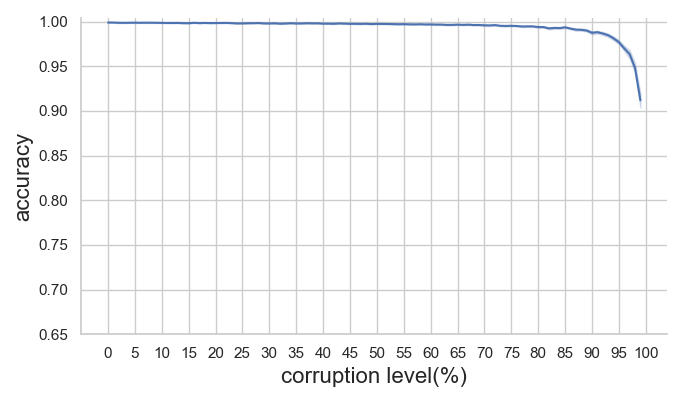

In [437]:
ax = sns.relplot(data=lin_dimensional_data[4], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.65, 1., 8))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set_yticklabels(ax.ax.get_yticks(), size = 11)
#ax.set_xticklabels(ax.ax.get_xticks(), size = 11)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_percent_dimensions_4.png', dpi=200)

#### 10 Dimensions

<IPython.core.display.Javascript object>


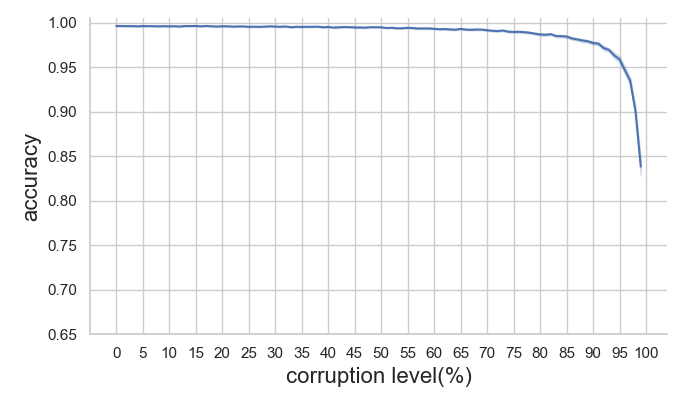

In [439]:
ax = sns.relplot(data=lin_dimensional_data[10], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.65, 1., 8))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_percent_dimensions_10.png', dpi=200)

#### 25 Dimensions

<IPython.core.display.Javascript object>


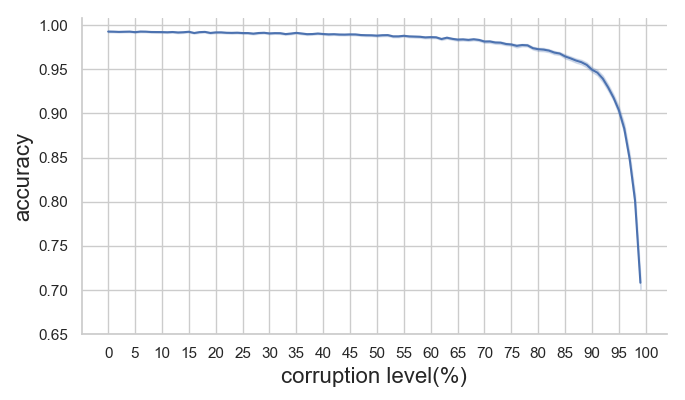

In [440]:
ax = sns.relplot(data=lin_dimensional_data[25], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.65, 1., 8))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_percent_dimensions_25.png', dpi=200)

#### 50 Dimensions

<IPython.core.display.Javascript object>


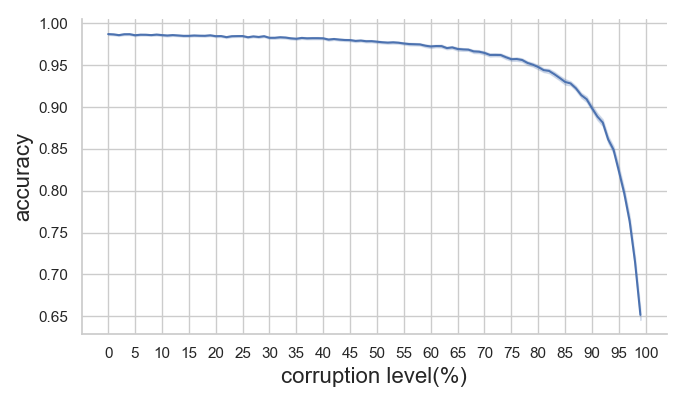

In [441]:
ax = sns.relplot(data=lin_dimensional_data[50], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.65, 1., 8))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_percent_dimensions_50.png', dpi=200)

#### 100 Dimensions

<IPython.core.display.Javascript object>


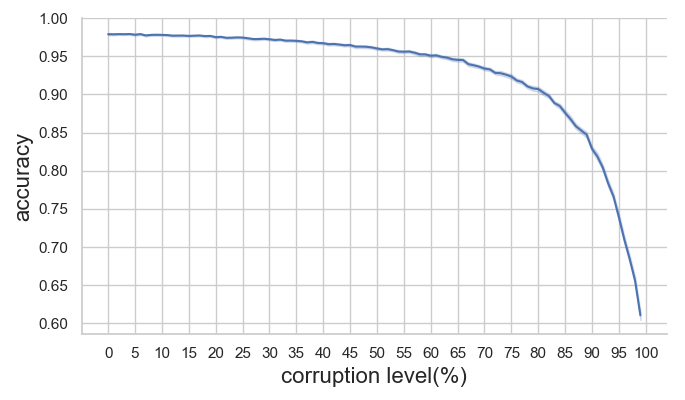

In [443]:
ax = sns.relplot(data=lin_dimensional_data[100], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.6, 1., 9))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_percent_dimensions_100.png', dpi=200)

## Worst Case Scenarios

#### 4 Dimensions

<IPython.core.display.Javascript object>


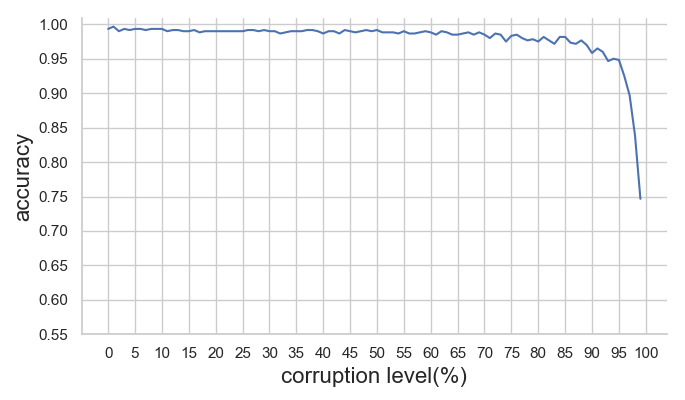

In [566]:
ax = sns.relplot(data=pd.DataFrame(lin_dimensional_data[4]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.55, 1., 10))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set_yticklabels(ax.ax.get_yticks(), size = 11)
#ax.set_xticklabels(ax.ax.get_xticks(), size = 11)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_worst_dimensions_4.png', dpi=200)

#### 10 Dimensions

<IPython.core.display.Javascript object>


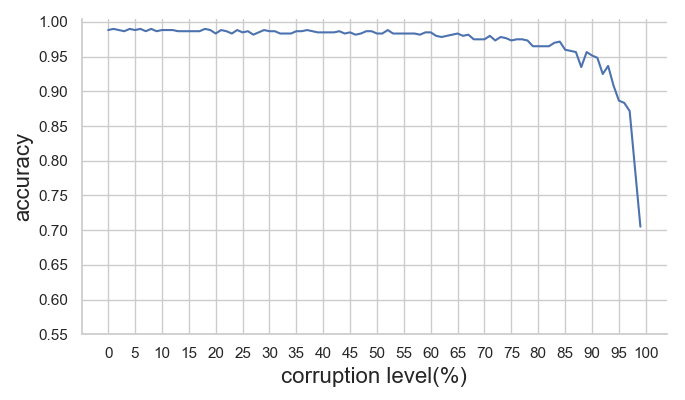

In [565]:
ax = sns.relplot(data=pd.DataFrame(lin_dimensional_data[10]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.55, 1., 10))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_worst_dimensions_10.png', dpi=200)

#### 25 Dimensions

<IPython.core.display.Javascript object>


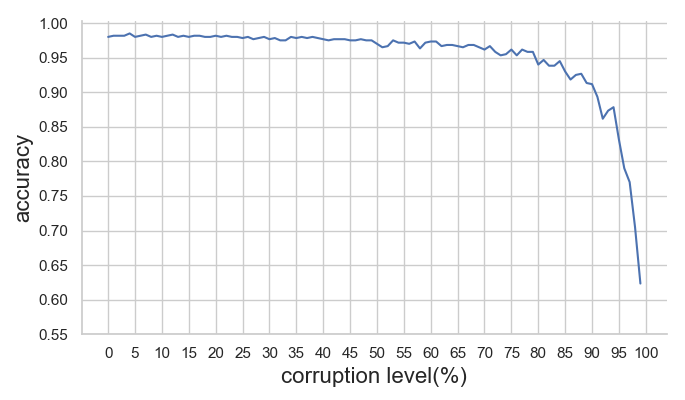

In [564]:
ax = sns.relplot(data=pd.DataFrame(lin_dimensional_data[25]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.55, 1., 10))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_worst_dimensions_25.png', dpi=200)

#### 50 Dimensions

<IPython.core.display.Javascript object>


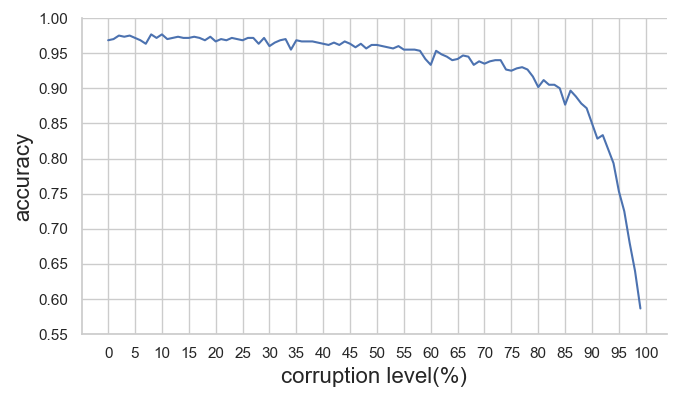

In [567]:
ax = sns.relplot(data=pd.DataFrame(lin_dimensional_data[50]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.55, 1., 10))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_worst_dimensions_50.png', dpi=200)

#### 100 Dimensions

<IPython.core.display.Javascript object>


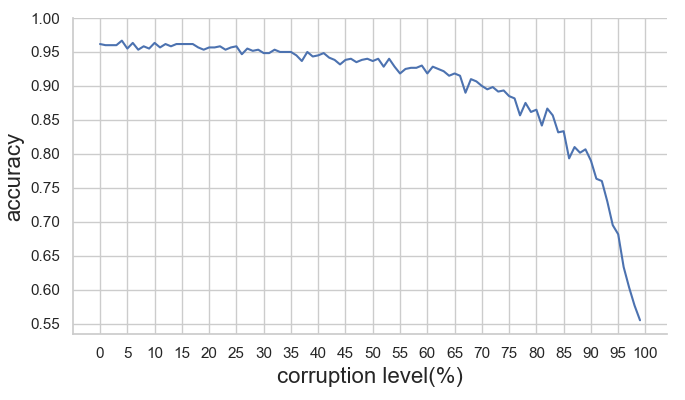

In [569]:
ax = sns.relplot(data=pd.DataFrame(lin_dimensional_data[100]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimensions')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.55, 1., 10))
ax.set_xlabels("corruption level(%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig(f'FinalResults/lin_worst_dimensions_100.png', dpi=200)

##### PAC Bounds

In [345]:
'''PAC Bounds according to P.M. Long on Half-spaces'''

pre_lin_and_bounds = []

lins_and_bounds = dict()

for dim in tqdm(total_dimensions):
    # Calculate Epsilon Lower Bounds
    total_data    = lin_pkl['n_data'] - 600
    total_buckets = lin_pkl['n_buckets']
    vc_dim        = (dim + 1) + 1 # Radon's Theorem
    delta         = 0.05

    epsilon_PAC = epsilon_PAC_complexity(
        total_data    = total_data, 
        total_buckets = total_buckets, 
        vc_dim        = vc_dim, 
        delta         = delta
    )
    
    # Create matching data frame that could be concatenated with data to produce seaborn plot
    epsilon_PAC = epsilon_PAC.assign(n_run=-1, dataset='Long (Halfspaces) Bound', Dimension=dim) 
    epsilon_PAC['score'] = epsilon_PAC.score.map(lambda x: x if x > 0. else np.NaN) # Mask invalid (negative) values

    '''Gallant Bounds on Pocket Perceptron'''
    # Dataset parameters
    total_data    = lin_pkl['n_data'] - 600
    total_buckets = lin_pkl['n_buckets']
    # Calculate epsilon knot
    lin_dataframe= pd.DataFrame(history_lin[dim]).drop('L', axis=1)
    epsilon_knot  = 1 - lin_dataframe.mean().mean()
    #epsilon_knot  = 0.05
    vc_dim        = (dim + 1) + 1 # Radon's Theorem
    delta         = 0.05
    L             = pd.DataFrame(history_lin[dim]['L']).max().max()
    # vc_dim = 10 # Gallant's paper comparison of results
    epsilon_pocket = epsilon_pocket_complexity(total_data=total_data, total_buckets=total_buckets, epsilon_knot=epsilon_knot, delta=delta, vc_dim=vc_dim, L=L)
    # Make data match results from experiments' parameters
    epsilon_pocket = epsilon_pocket.assign(n_run=-1, dataset='Pocket Gallant Bound', Dimension=dim)
    #epsilon_pocket = epsilon_pocket[lin_pocket_err.buckets < n_buckets] # Set limit of n samples. (Else, we get up to ~50,000)


    # Creates new columns dataset to identify between scores from actual results and PAC analysis
    pre_concat = [
        pd.DataFrame(lin_dimensional_data[dim]).assign(dataset='Mean Accuracy'), 
        epsilon_PAC,
        epsilon_pocket
    ]

    # Final data table
    pre_lin_and_bounds.append(pd.concat(pre_concat).reset_index(drop=True))


lin_and_bounds = pd.concat(pre_lin_and_bounds).reset_index(drop=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:49<00:00, 45.87s/it]


In [346]:
lin_and_bounds

score  corruption  n_run  Dimension               dataset
0      0.910000          99      0          4         Mean Accuracy
1      0.938333          99      1          4         Mean Accuracy
2      0.911667          99      2          4         Mean Accuracy
3      0.848333          99      3          4         Mean Accuracy
4      0.936667          99      4          4         Mean Accuracy
...         ...         ...    ...        ...                   ...
50795  0.474820           4     -1        100  Pocket Gallant Bound
50796  0.477176           3     -1        100  Pocket Gallant Bound
50797  0.479496           2     -1        100  Pocket Gallant Bound
50798  0.481781           1     -1        100  Pocket Gallant Bound
50799  0.484031           0     -1        100  Pocket Gallant Bound

[50800 rows x 5 columns]

In [495]:
# Plot Configuration
height = 4
aspect = 12/6

#### Bounded Scores

Here we can appreciate the bounds produced by the bounds given by Long (Half Spaces) and Gallant (Pocket Algorithm).

In [496]:
tmp = lin_and_bounds

In [497]:
tmp.drop(lin_and_bounds[lin_and_bounds.dataset=='Long (Halfspaces) Bound'].index, inplace=True)

<IPython.core.display.Javascript object>


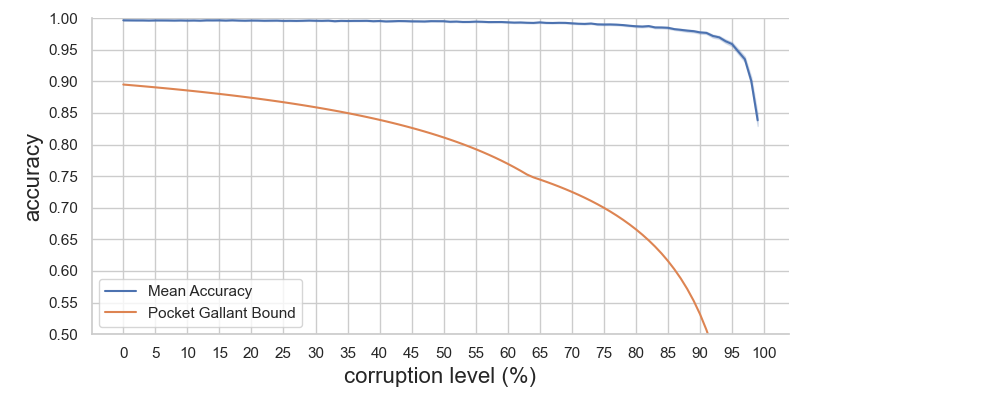

In [498]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[lin_and_bounds.Dimension == 10], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='lower left')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.5, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/lin_bounds_dimension_10.png', dpi=200)

<IPython.core.display.Javascript object>


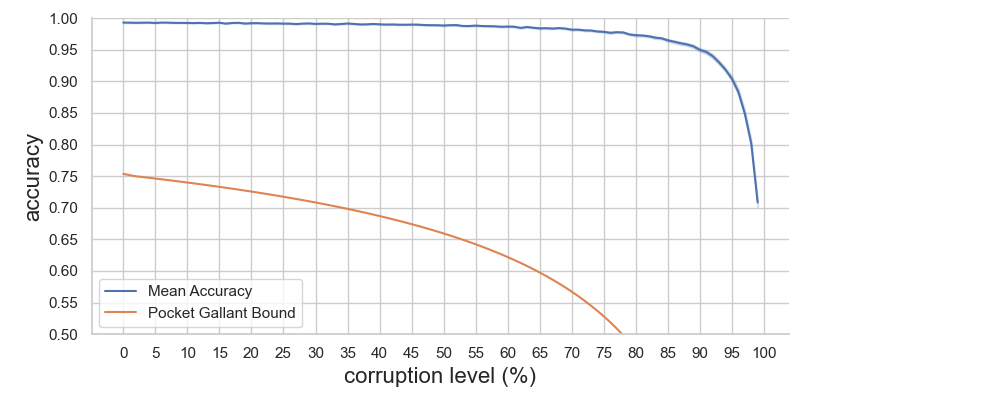

In [499]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[lin_and_bounds.Dimension == 25], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='lower left')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.5, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/lin_bounds_dimension_25.png', dpi=200)

<IPython.core.display.Javascript object>


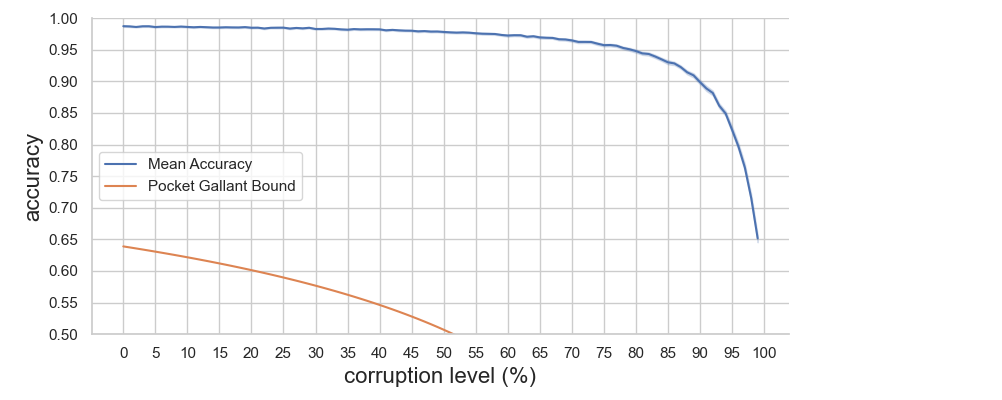

In [500]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[lin_and_bounds.Dimension == 50], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='center left')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.5, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/lin_bounds_dimension_50.png', dpi=200)

<IPython.core.display.Javascript object>


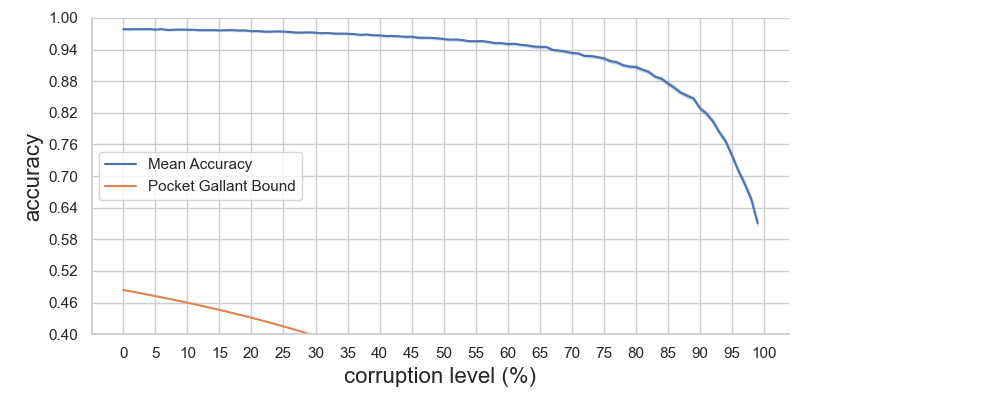

In [501]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[lin_and_bounds.Dimension == 100], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='center left')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.4, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/lin_bounds_dimension_100.png', dpi=200)

### 3D Plots

<IPython.core.display.Javascript object>


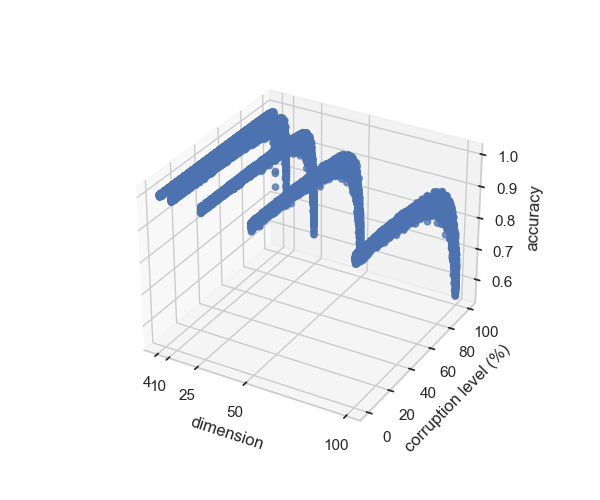

In [237]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = lin_dimensional_df['Dimension']
y1 =lin_dimensional_df['corruption']
z1 =lin_dimensional_df['score'] 
axes.scatter3D(x1, y1, z1, alpha=0.75)

axes.set_xlabel('dimension')
axes.set_xticks([4, 10, 25, 50, 100])
axes.set_ylabel('corruption level (%)')
axes.set_zlabel('accuracy')
#axes.set_title('Accuracy Scores per Buckets/Dimension')

plt.show()
axes.figure.savefig(f'FinalResults/lin_scores_3D.png', dpi=200)

#### Accuracy Score Means

In [427]:
scores = lin_dimensional_df.groupby(['corruption', 'Dimension']).mean()
indices = pd.DataFrame([*scores.index], columns=['corruption', 'Dimension'])

<IPython.core.display.Javascript object>


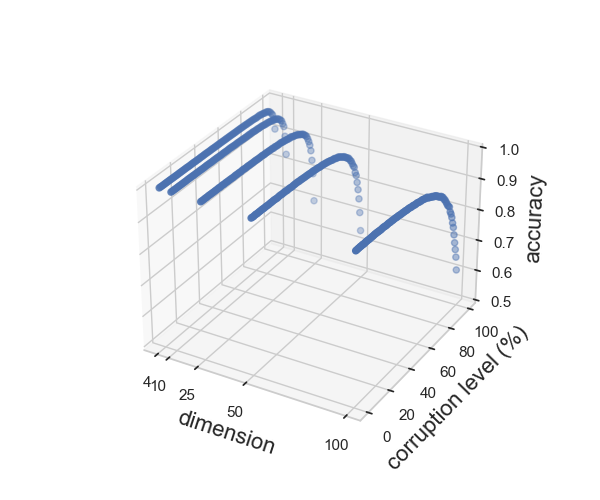

In [428]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = indices['Dimension']
y1 = indices['corruption']
z1 = scores['score']
axes.scatter3D(x1, y1, z1)

axes.set_xlabel('dimension', fontsize=16)
axes.set_xticks([4, 10, 25, 50, 100])
axes.set_zlim([0.5, 1.0])
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)', fontsize=16)
axes.set_zlabel('accuracy', fontsize=16)
#axes.set_title("Average Accuracy per Bucket/Dimension")

plt.show()
axes.figure.savefig(f'FinalResults/lin_means_3D.png', dpi=200)

<IPython.core.display.Javascript object>


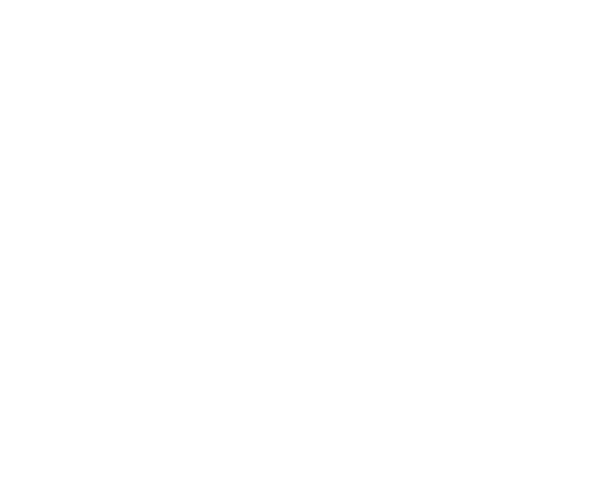

In [307]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = indices['Dimension']
y1 = indices['corruption']
z1 = scores['score']
axes.plot_trisurf(x1, y1, z1, linewidth=0, shade=False, edgecolor='none', antialiased=False, cmap=plt.cm.winter)

axes.set_xlabel('dimension', fontsize=16)
axes.set_xticks([4, 10, 25, 50, 100])
#plt.xticks(rotation = 45)
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)')
axes.set_zlabel('accuracy')

plt.show()
axes.figure.savefig(f'FinalResults/lin_mean_surface_3D.png', dpi=200)

#### Accuracy Worst Scores

In [450]:
scores = lin_dimensional_df.groupby(['corruption', 'Dimension']).min()
indices = pd.DataFrame([*scores.index], columns=['corruption', 'Dimension'])

<IPython.core.display.Javascript object>


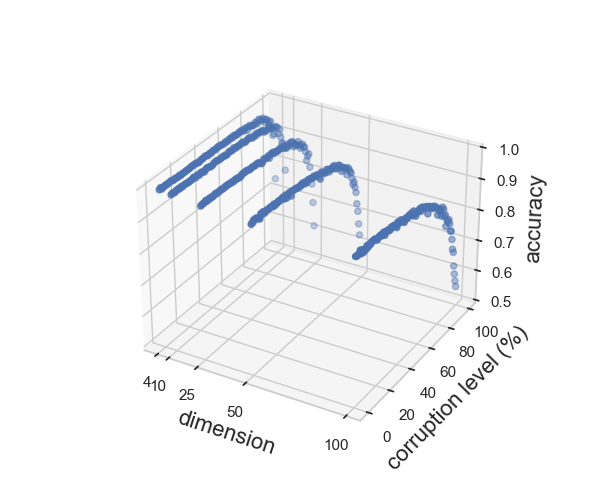

In [451]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = indices['Dimension']
y1 = indices['corruption']
z1 = scores['score']
axes.scatter3D(x1, y1, z1)


axes.set_xlabel('dimension', fontsize=16)
axes.set_xticks([4, 10, 25, 50, 100])
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)', fontsize=16)
axes.set_zlabel('accuracy', fontsize=16)
axes.set_zlim([0.5, 1.0])


plt.show()
axes.figure.savefig(f'FinalResults/lin_worst_3D.png', dpi=200)

<IPython.core.display.Javascript object>


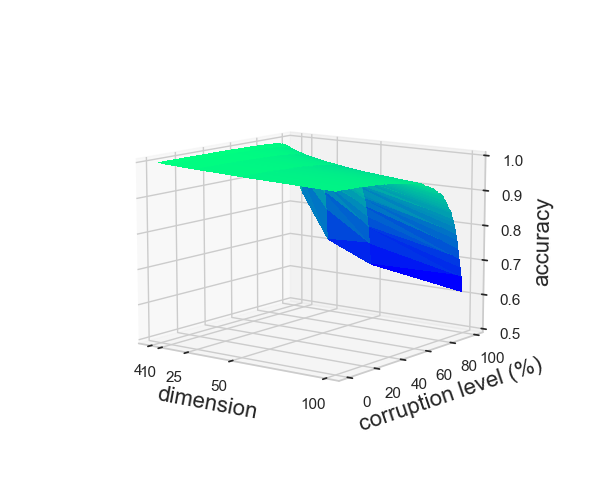

In [429]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = indices['Dimension']
y1 = indices['corruption']
z1 = scores['score']
axes.plot_trisurf(x1, y1, z1, linewidth=0, shade=False, edgecolor='none', antialiased=False, cmap=plt.cm.winter)


axes.set_xlabel('dimension', fontsize=16)
axes.set_xticks([4, 10, 25, 50, 100], fontsize=10)
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)', fontsize=16)
axes.set_zlabel('accuracy', fontsize=16)
axes.set_zlim([0.5, 1.0])


plt.show()
axes.figure.savefig(f'lin_worst_surface_3D.png', dpi=200)

#### Synthetic Linearly-Non Separable
<a id="syn-non-plot"></a>

#### 4 Dimensions

In [457]:
# Plot Configuration
height = 4
aspect = 12/7
dimension = 100

<IPython.core.display.Javascript object>


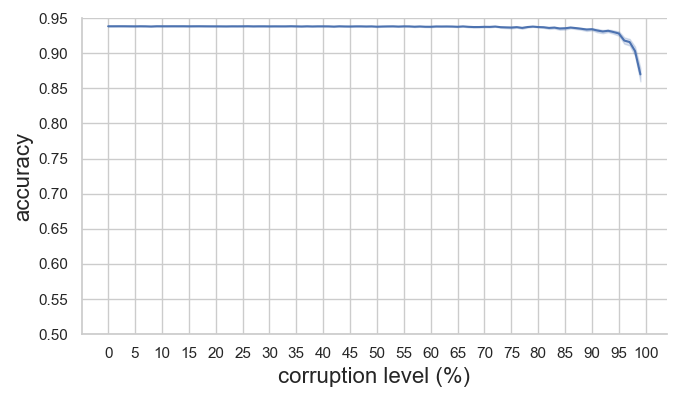

In [466]:
ax = sns.relplot(data=non_dimensional_data[4], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.5, 0.95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 10))
ax.figure.savefig(f'FinalResults/non_percent_dimensions_4.png', dpi=200)
#plt.show()

#### 10 Dimensions

<IPython.core.display.Javascript object>


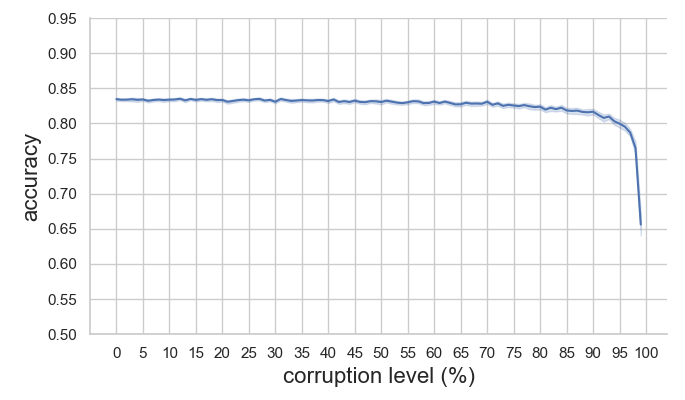

In [467]:
ax = sns.relplot(data=non_dimensional_data[10], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.5, .95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 10))
ax.figure.savefig(f'FinalResults/non_percent_dimensions_10.png', dpi=200)
#plt.show()

#### 25 Dimensions

<IPython.core.display.Javascript object>


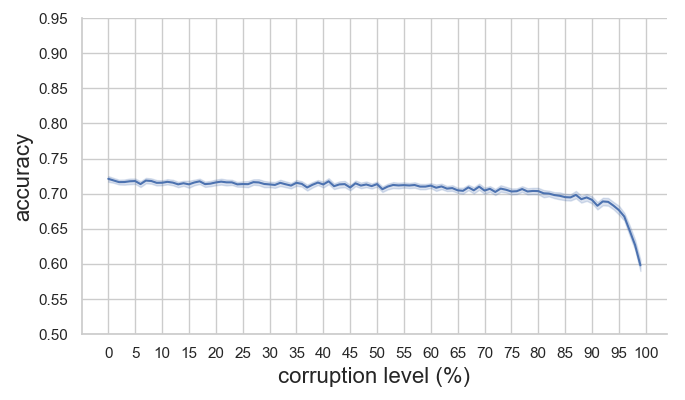

In [468]:
ax = sns.relplot(data=non_dimensional_data[25], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.5, 0.95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 10))
ax.figure.savefig(f'FinalResults/non_percent_dimensions_25.png', dpi=200)
#plt.show()

#### 50 Dimensions

<IPython.core.display.Javascript object>


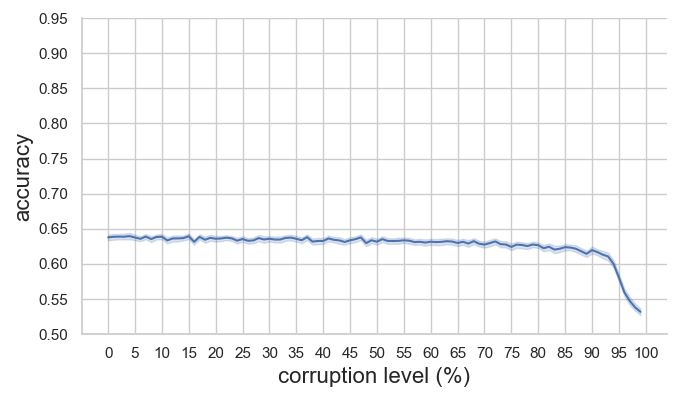

In [469]:
ax = sns.relplot(data=non_dimensional_data[50], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.5, 0.95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 10))
ax.figure.savefig(f'FinalResults/non_percent_dimensions_50.png', dpi=200)
#plt.show()

#### 100 Dimensions

<IPython.core.display.Javascript object>


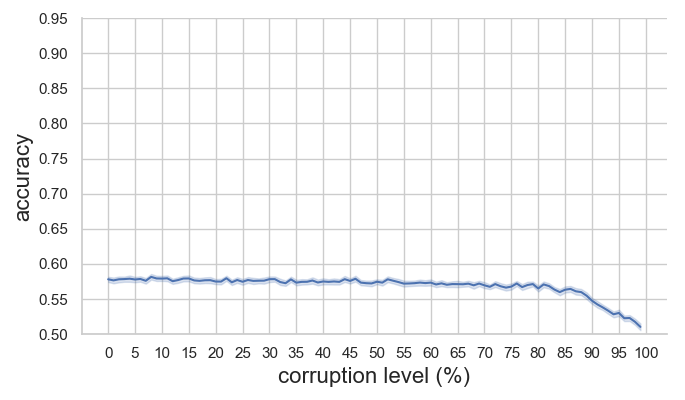

In [470]:
ax = sns.relplot(data=non_dimensional_data[100], kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.5, 0.95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 10))
ax.figure.savefig(f'FinalResults/non_percent_dimensions_100.png', dpi=200)
#plt.show()

## Worst Case Scenarios

#### 4 Dimensions

In [541]:
# Plot Configuration
height = 4
aspect = 12/7
dimension = 100

<IPython.core.display.Javascript object>


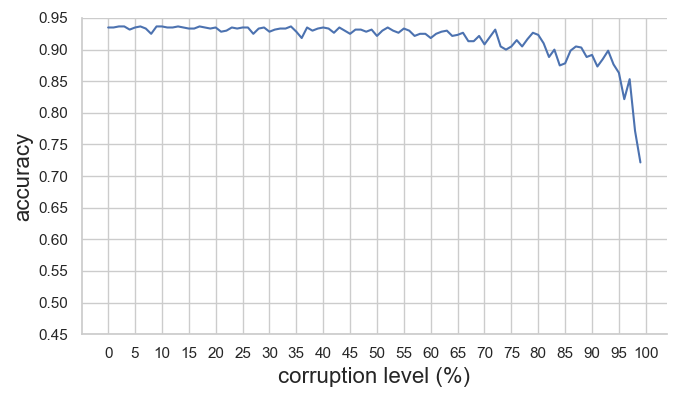

In [561]:
ax = sns.relplot(data=pd.DataFrame(non_dimensional_data[4]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.45, 0.95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.figure.savefig(f'FinalResults/non_worst_dimensions_4.png', dpi=200)
#plt.show()

#### 10 Dimensions

<IPython.core.display.Javascript object>


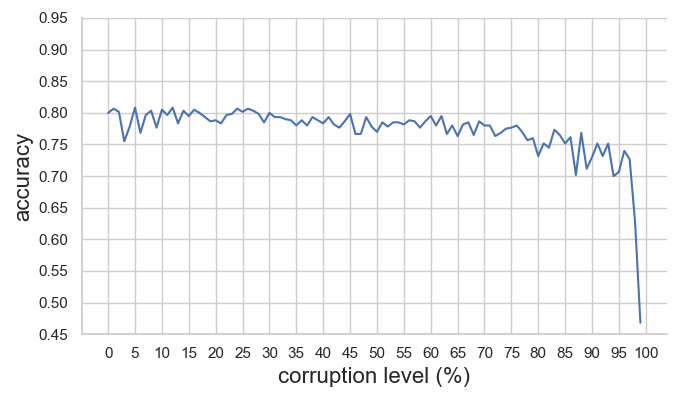

In [560]:
ax = sns.relplot(data=pd.DataFrame(non_dimensional_data[10]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.45, .95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.figure.savefig(f'FinalResults/non_worst_dimensions_10.png', dpi=200)
#plt.show()

#### 25 Dimensions

<IPython.core.display.Javascript object>


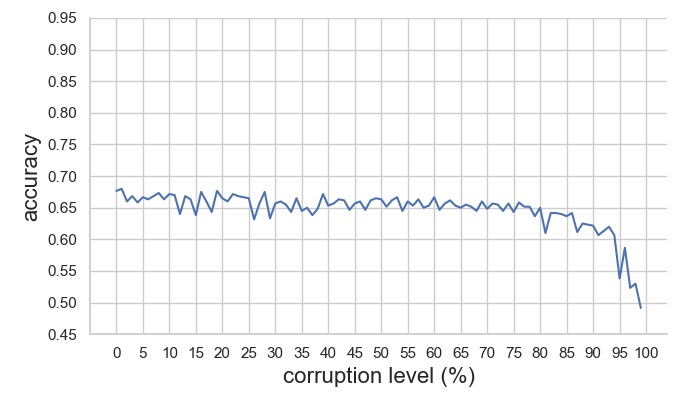

In [572]:
ax = sns.relplot(data=pd.DataFrame(non_dimensional_data[25]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.45, 0.95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.figure.savefig(f'FinalResults/non_worst_dimensions_25.png', dpi=200)
#plt.show()

#### 50 Dimensions

<IPython.core.display.Javascript object>


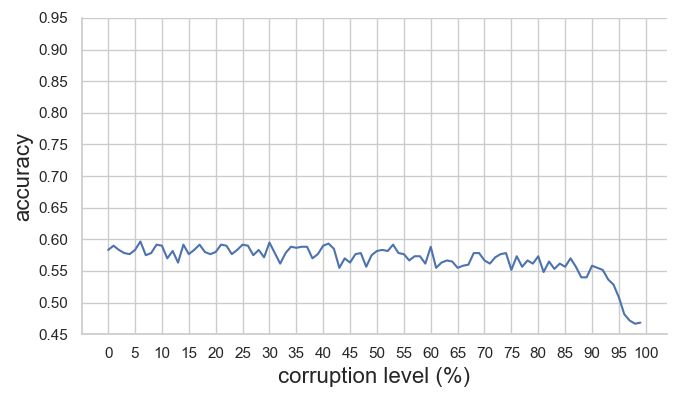

In [558]:
ax = sns.relplot(data=pd.DataFrame(non_dimensional_data[50]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.45, 0.95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.figure.savefig(f'FinalResults/non_worst_dimensions_50.png', dpi=200)
#plt.show()

#### 100 Dimensions

<IPython.core.display.Javascript object>


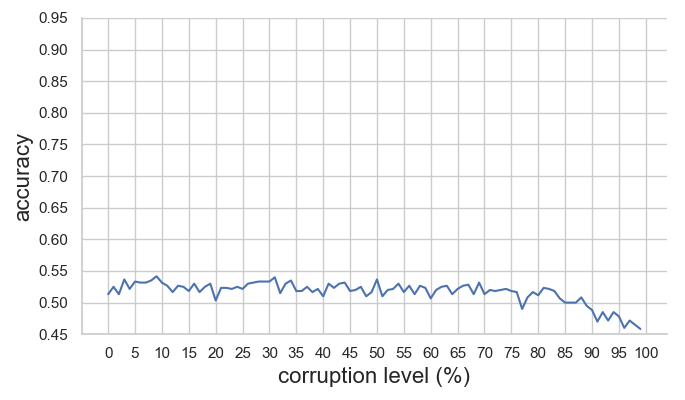

In [557]:
ax = sns.relplot(data=pd.DataFrame(non_dimensional_data[100]).groupby(['corruption']).min(), kind='line', x='corruption', y='score', height=height, aspect=aspect)

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Accuracy vs Buckets Used per Dimension')

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
ax.set_xlabels("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.45, 0.95
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.figure.savefig(f'FinalResults/non_worst_dimensions_100.png', dpi=200)
#plt.show()

### 3D Plots

<IPython.core.display.Javascript object>


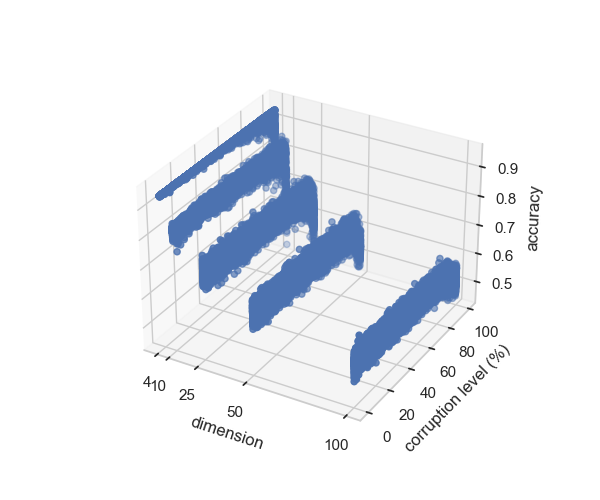

In [196]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = non_dimensional_df['Dimension']
y1 = non_dimensional_df['corruption']
z1 =non_dimensional_df['score']
axes.scatter3D(x1, y1, z1)

axes.set_xlabel('dimension')
axes.set_xticks([4, 10, 25, 50, 100])
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)')
axes.set_zlabel('accuracy')

#plt.show()
axes.figure.savefig(f'FinalResults/non_scores_3D.png', dpi=200)

#### Average Scores

In [472]:
scores = non_dimensional_df.groupby(['corruption', 'Dimension']).mean()
indices = pd.DataFrame([*scores.index], columns=['corruption', 'Dimension'])

<IPython.core.display.Javascript object>


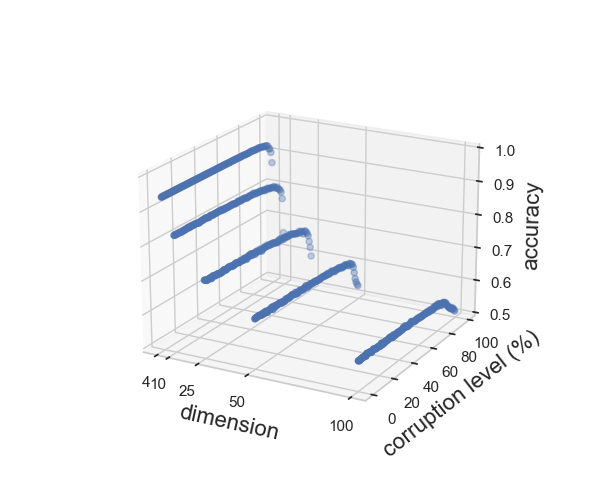

In [431]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = indices['Dimension']
y1 = indices['corruption']
z1 = scores['score']
axes.scatter3D(x1, y1, z1)


axes.set_xlabel('dimension', fontsize=16)
axes.set_xticks([4, 10, 25, 50, 100])
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)', fontsize=16)
axes.set_zlabel('accuracy', fontsize=16)
axes.set_zlim([0.5, 1.0])

axes.figure.savefig(f'FinalResults/non_mean_3D.png', dpi=200)
#plt.show()

<IPython.core.display.Javascript object>


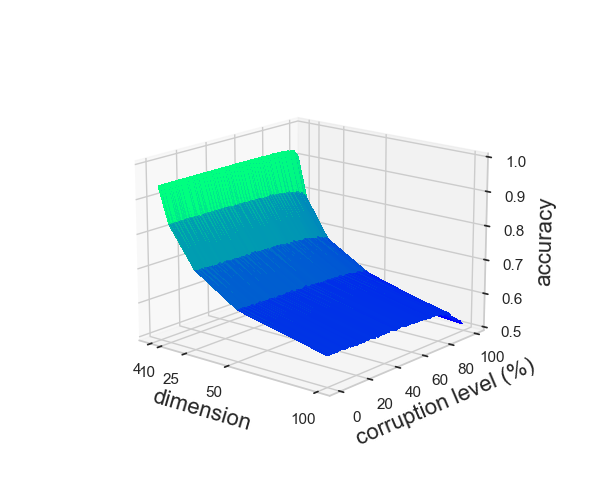

In [473]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = indices['Dimension']
y1 = indices['corruption']
z1 = scores['score']
axes.plot_trisurf(x1, y1, z1, linewidth=0, shade=True, edgecolor='none', antialiased=False, cmap=plt.cm.winter, )

axes.set_zlim([0.5, 1.])
axes.set_xlabel('dimension', fontsize=16)
axes.set_xticks([4, 10, 25, 50, 100])
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)', fontsize=16)
axes.set_zlabel('accuracy', fontsize=16)


axes.figure.savefig(f'FinalResults/non_mean_surface_3D.png', dpi=200)
#plt.show()

#### Worst Scores

In [447]:
scores = non_dimensional_df.groupby(['corruption', 'Dimension']).min()
indices = pd.DataFrame([*scores.index], columns=['corruption', 'Dimension'])

<IPython.core.display.Javascript object>


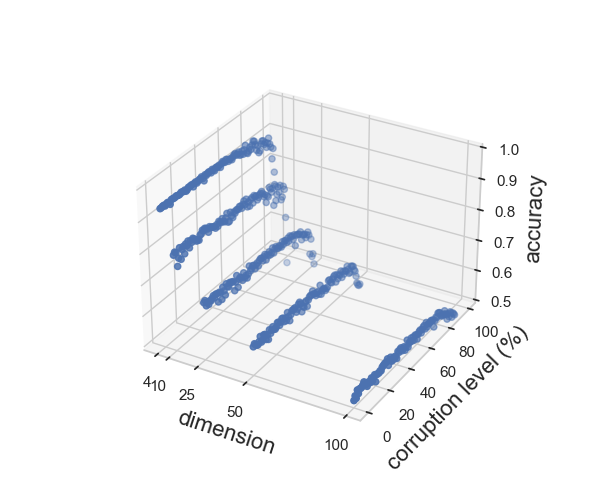

In [448]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = indices['Dimension']
y1 = indices['corruption']
z1 = scores['score']
axes.scatter3D(x1, y1, z1)

axes.set_zlim([0.5, 1.])
axes.set_xlabel('dimension', fontsize=16)
axes.set_xticks([4, 10, 25, 50, 100])
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)', fontsize=16)
axes.set_zlabel('accuracy', fontsize=16)

axes.figure.savefig(f'FinalResults/non_worst_3D.png', dpi=200)
#plt.show()

<IPython.core.display.Javascript object>


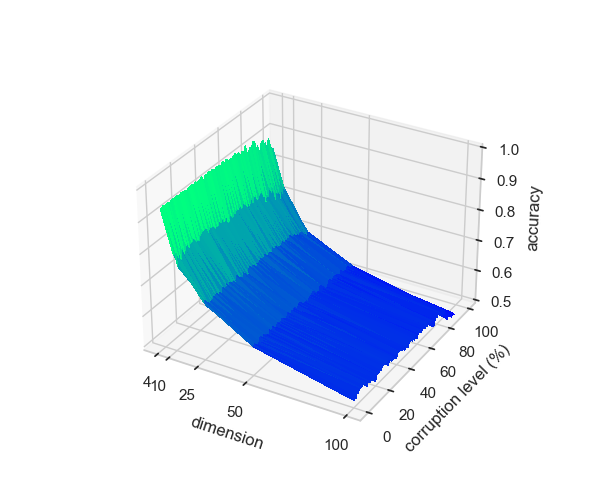

In [202]:
plt.figure(figsize=(6,5))
axes = plt.axes(projection='3d')
x1 = indices['Dimension']
y1 = indices['corruption']
z1 = scores['score']
axes.plot_trisurf(x1, y1, z1, linewidth=0, shade=False, edgecolor='none', antialiased=False, cmap=plt.cm.winter)

axes.set_zlim([0.5, 1.])
axes.set_xlabel('dimension')
axes.set_xticks([4, 10, 25, 50, 100])
#axes.set_yticks([x for x in range()])
axes.set_ylabel('corruption level (%)')
axes.set_zlabel('accuracy')


axes.figure.savefig(f'FinalResults/non_worst_surface_3D.png', dpi=200)
#plt.show()

##### PAC Bounds

In [352]:
'''PAC Bounds according to P.M. Long on Half-spaces'''
# Calculate Epsilon Lower Bounds
pre_non_and_bounds = []

for dim in tqdm(total_dimensions):

    total_data    = non_lin_pkl['n_data'] - 600
    total_buckets = non_lin_pkl['n_buckets'] 
    vc_dim        = (dim + 1) + 1 # Radon's Theorem
    delta         = 0.01

    epsilon_PAC = epsilon_PAC_complexity(total_data=total_data, total_buckets=total_buckets, vc_dim=vc_dim, delta=delta)

    # Create matching data frame that could be concatenated with data to produce seaborn plot
    epsilon_PAC = epsilon_PAC.assign(n_run=-1, dataset='Long (Halfspaces) Bound', Dimension=dim) 
    epsilon_PAC['score'] = epsilon_PAC.score.map(lambda x: x if x > 0. else np.NaN) # Mask invalid (negative) values


    '''Gallant Bounds on Pocket Perceptron'''
    # Dataset parameters
    total_data    = non_lin_pkl['n_data'] - 600
    total_buckets = non_lin_pkl['n_buckets']
    # Calculate epsilon knot
    non_lin_dataframe= pd.DataFrame(history_non[dim]).drop('L', axis=1)
    epsilon_knot  = 1 - non_lin_dataframe.mean().mean()
    #epsilon_knot  = 0.01
    vc_dim        = non_lin_pkl['n_attribs'] + 1 # Radon's Theorem
    delta         = 0.01
    L             = pd.DataFrame(history_non[dim]['L']).max().max()
    # vc_dim = 10 # Gallant's paper comparison of results
    epsilon_pocket = epsilon_pocket_complexity(total_data=total_data, total_buckets=total_buckets, epsilon_knot=epsilon_knot, delta=delta, vc_dim=vc_dim, L=L)

    # Make data match results from experiments' parameters
    epsilon_pocket = epsilon_pocket.assign(n_run=-1, dataset='Gallant Bound', Dimension=dim)
    #epsilon_pocket = epsilon_pocket[lin_pocket_err.buckets < n_buckets] # Set limit of n samples. (Else, we get up to ~50,000)


    # Creates new columns dataset to identify between scores from actual results and PAC analysis
    pre_concat = [
        pd.DataFrame(non_dimensional_data[dim]).assign(dataset='Mean Accuracy'), 
        epsilon_PAC,
        epsilon_pocket
    ]

    # Final data table
    pre_non_and_bounds.append(pd.concat(pre_concat).reset_index(drop=True))


non_lin_and_bounds = pd.concat(pre_non_and_bounds).reset_index(drop=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:41<00:00, 44.32s/it]


In [477]:
non_lin_and_bounds.dataset.value_counts()

Mean Accuracy              50000
Gallant Bound                500
Long (Halfspaces) Bound      500
Name: dataset, dtype: int64

In [505]:
tmp = non_lin_and_bounds

In [506]:
tmp.drop(non_lin_and_bounds[non_lin_and_bounds.dataset=='Long (Halfspaces) Bound'].index, inplace=True)

In [479]:
non_lin_and_bounds[non_lin_and_bounds.dataset=='Long (Halfspaces) Bound'].index


Int64Index([10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008,
            10009,
            ...
            50890, 50891, 50892, 50893, 50894, 50895, 50896, 50897, 50898,
            50899],
           dtype='int64', length=500)

In [507]:
# Plot Configuration
height = 4
aspect = 12/6

<IPython.core.display.Javascript object>


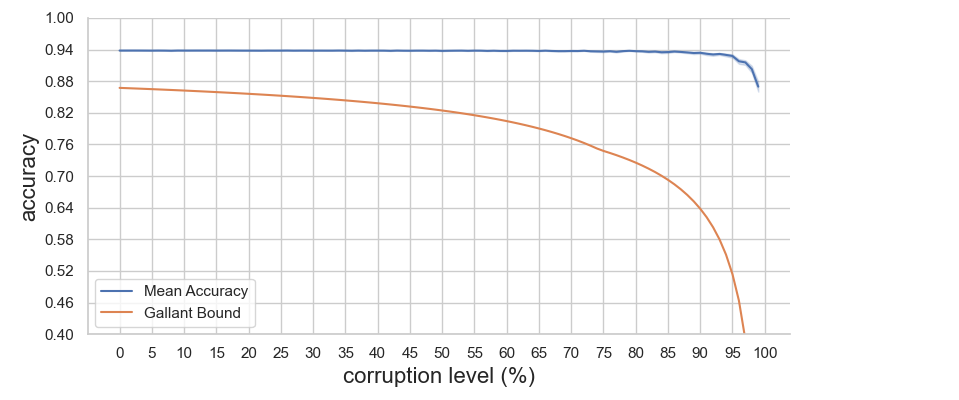

In [508]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[non_lin_and_bounds.Dimension == 4], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='lower left')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.4, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/non_bounds_dimension_4.png', dpi=200)

<IPython.core.display.Javascript object>


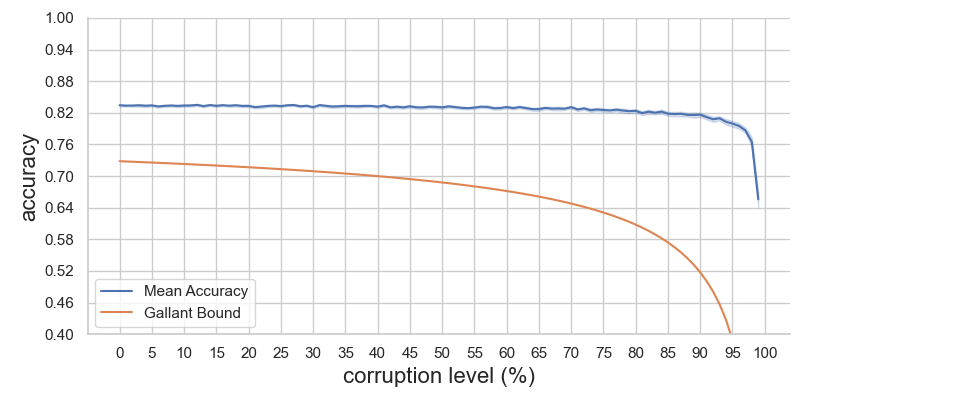

In [509]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[non_lin_and_bounds.Dimension == 10], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='lower left')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.4, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/non_bounds_dimension_10.png', dpi=200)

<IPython.core.display.Javascript object>


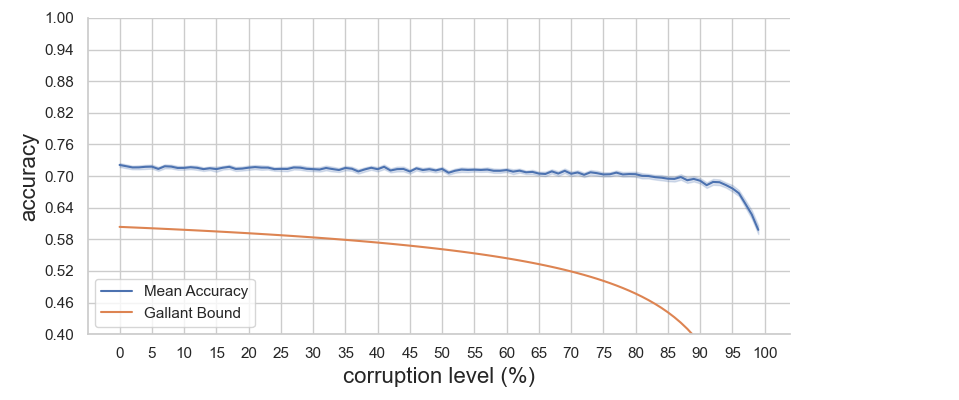

In [510]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[non_lin_and_bounds.Dimension == 25], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='lower left')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.4, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/non_bounds_dimension_25.png', dpi=200)

<IPython.core.display.Javascript object>


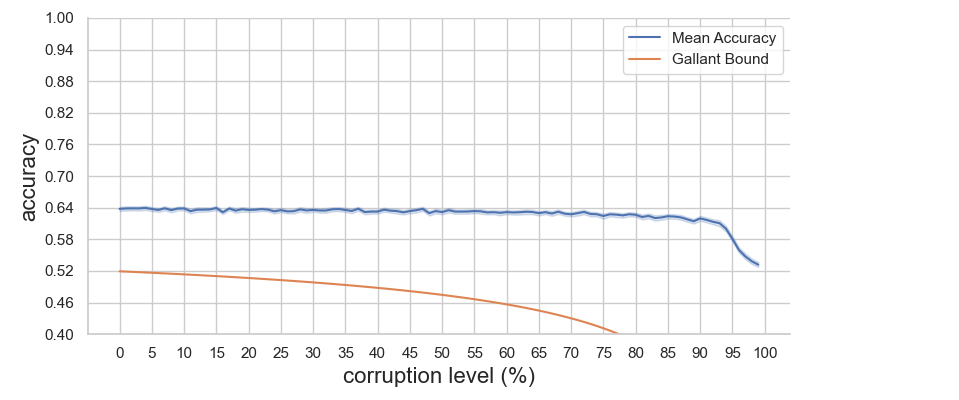

In [511]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[non_lin_and_bounds.Dimension == 50], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='best')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.4, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/non_bounds_dimension_50.png', dpi=200)

<IPython.core.display.Javascript object>


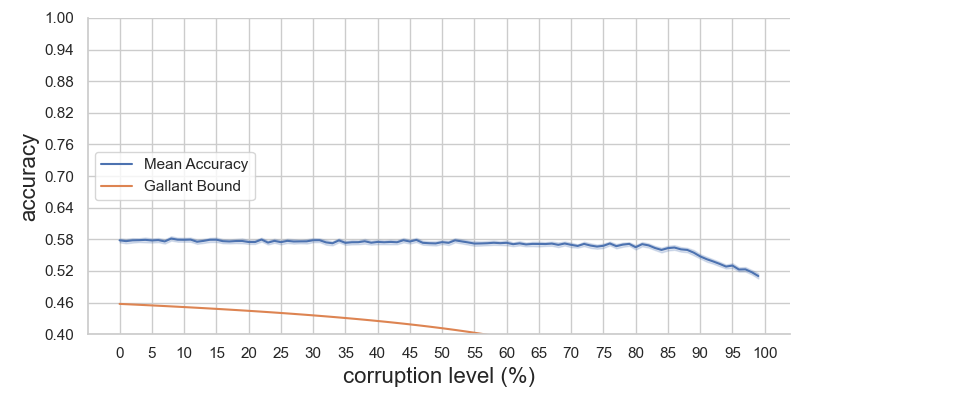

In [512]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp[non_lin_and_bounds.Dimension == 100], kind='line', x='corruption', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='center left')
#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.
ax._legend.remove()

#ax.fig.subplots_adjust(top=0.9)
#ax.fig.suptitle('Score vs Buckets Used')

plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.4, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.set_xlabels("corruption level (%)", fontsize=16)
ax.set_ylabels("accuracy", fontsize=16)
#plt.title("Synthetic Linearly-Separable")
#plt.show()
ax.figure.savefig(f'FinalResults/non_bounds_dimension_100.png', dpi=200)

In [391]:
non_lin_and_bounds.iloc[50903]

score            0.00912906
corruption               96
n_run                    -1
Dimension               100
dataset       Gallant Bound
Name: 50903, dtype: object

In [513]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=non_lin_and_bounds, kind='line', x='buckets', y='score', col='Dimension', col_wrap=2, hue='dataset', height=height, aspect=aspect)
plt.legend(loc='lower right')
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle("Synthetic Non Linearly-Separable")

#ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(non_lin_pkl['n_data']/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
scr_min, scr_max = 0.5, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))



ax.set_xlabels("Percentage of Data Corrupted")
#plt.title("Synthetic Non Linearly-Separable")
#ax.set(title='Score vs Buckets Used')
ax.figure.savefig('FinalResults/non_bounds.png', dpi=200)
#plt.show()

ValueError: Could not interpret value `buckets` for parameter `x`

## Box Plots

In [12]:
height = 4
aspect = 12/7
PROPS = {
    'boxprops':{'facecolor':'whitesmoke', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops': {'color': 'green'}
}

### Synthetic Datasets

#### Linearly-Separable
<a id="syn-lin-box"></a>

<IPython.core.display.Javascript object>


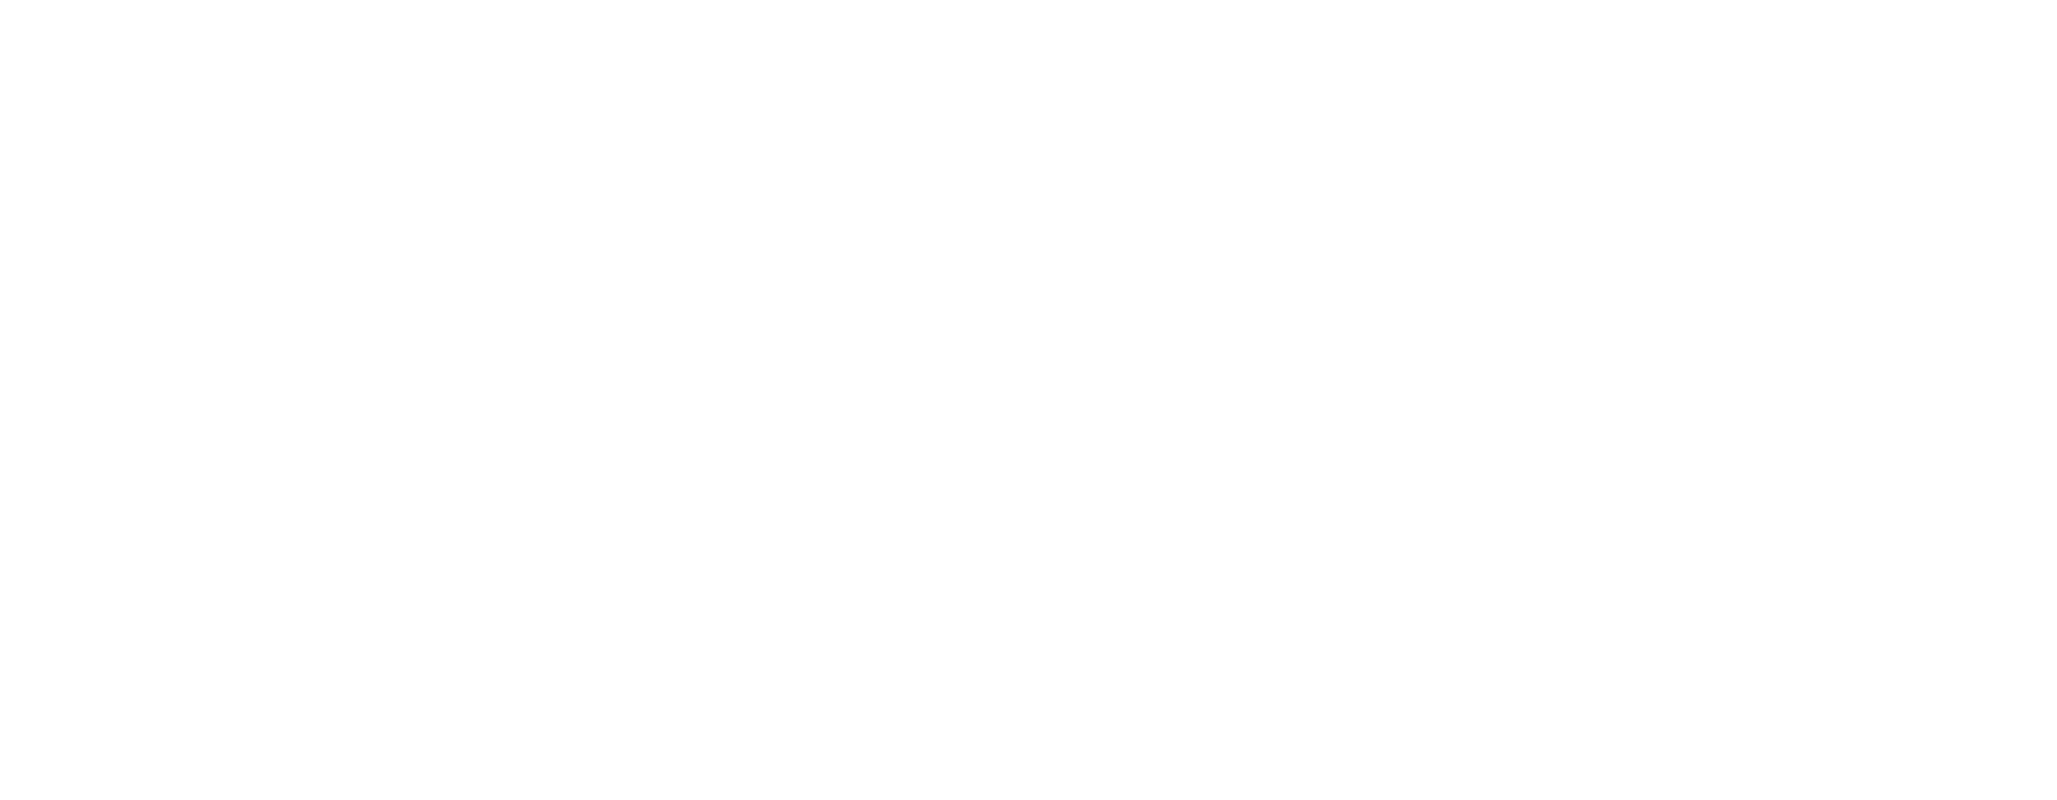

In [26]:
PROPS = {
    'boxprops':{'facecolor':'whitesmoke', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops': {'color': 'green'}
}

ax = sns.catplot(data=lin_dimensional_df, kind='box', x='buckets', y='score', col='Dimension', col_wrap=3, height=height, aspect=aspect, color='black', **PROPS)

# Figure Attributes (using pyplot)

ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Score vs Buckets Used')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
ax.set_xlabels("Percentage % Corrupted")
ax.set_ylabels('Accuracy')
plt.yticks(np.linspace(0.5, 1., 11))
ax.figure.savefig('FinalResults/lin_box_3D.png', dpi=200)

#plt.show()

<IPython.core.display.Javascript object>


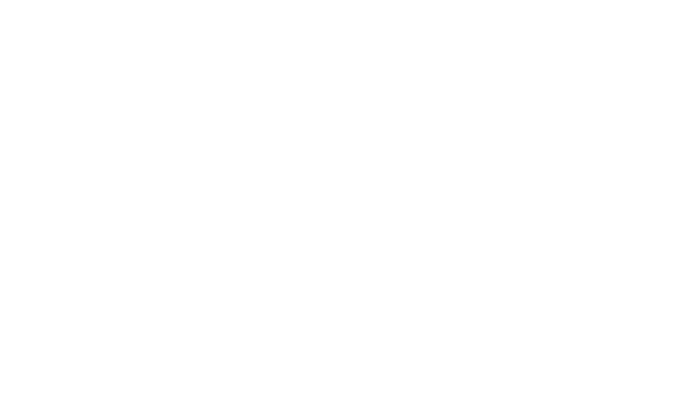

In [13]:
ax = sns.catplot(data=pd.DataFrame(lin_dimensional_data[4]), kind='box', x='buckets', y='score', height=height, aspect=aspect, color='black', **PROPS, saturation=0.1)
# Figure Attributes (using pyplot)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Score vs Buckets Used')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.5, 1., 11))
#plt.show()
ax.figure.savefig('img_results/lin_box.png', dpi=200)

#### Non-Linearly Separable
<a id="syn-non-box"></a>

<IPython.core.display.Javascript object>


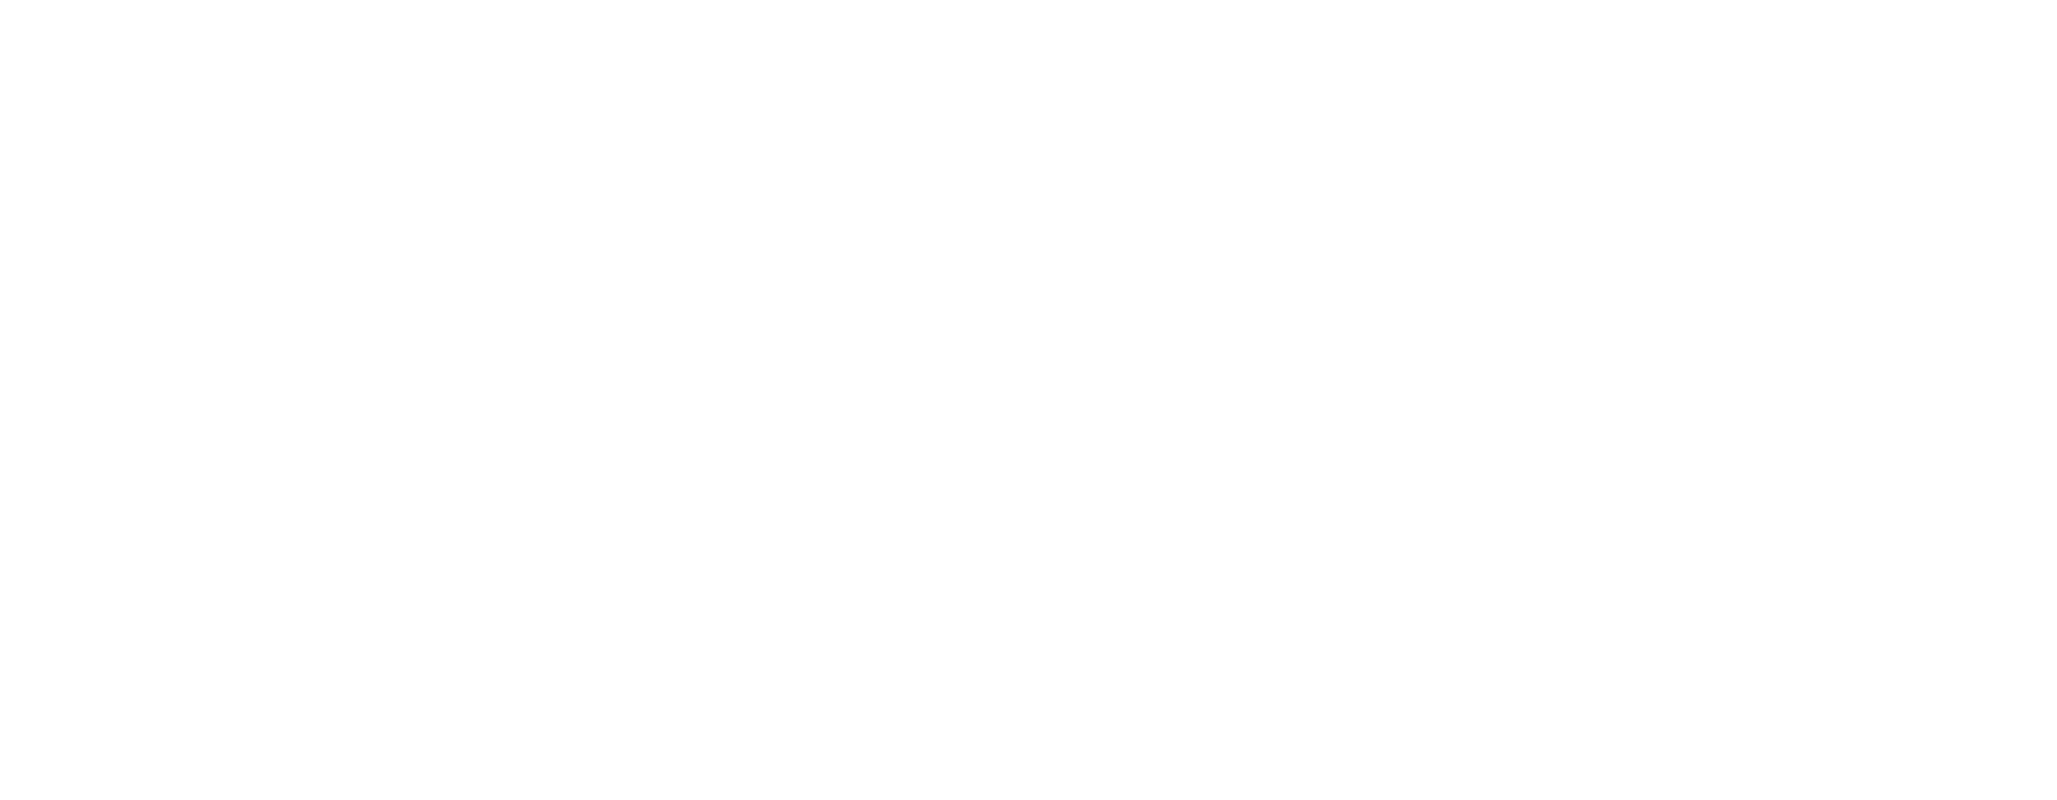

In [25]:
ax = sns.catplot(data=non_dimensional_df, kind='box', x='buckets', y='score', col='Dimension', col_wrap=3, height=height, aspect=aspect, color='black', **PROPS, saturation=0.1)
# Figure Attributes (using pyplot)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Score vs Buckets Used')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
ax.set_xlabels("Percentage % Corrupted")
ax.set_ylabels('Accuracy')
plt.yticks(np.linspace(0.5, 1., 11))

ax.figure.savefig('FinalResults/non_box_3D.png', dpi=200)

#plt.show()

<IPython.core.display.Javascript object>


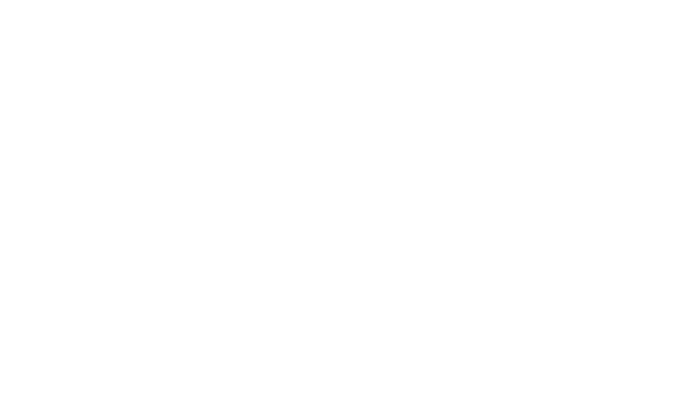

In [14]:
ax = sns.catplot(data=pd.DataFrame(non_dimensional_data[4]), kind='box', x='buckets', y='score', height=height, aspect=aspect, color='black', **PROPS, saturation=0.1)
# Figure Attributes (using pyplot)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Score vs Buckets Used')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.5, 1., 11))
#plt.show()
ax.figure.savefig('img_results/non_box_.png', dpi=200)

# Table

In [415]:
percents = 100 - np.array([0, 1, 2, 3, 5, 10, 25, 50, 75, 85, 90, 95, 96, 97, 98, 99,])
percentages = 100 - np.array(percents) 

### Synthetic Datasets

#### Linearly Separable
<a id="syn-lin-table"></a>

In [416]:
# Mean
lin_mean = lin_dimensional_df.groupby(['Dimension', 'corruption']).score.mean()
lin_mean = pd.DataFrame(lin_mean[[(dim, per) for dim in total_dimensions for per in percentages]])
lin_mean = lin_mean.rename(columns={0: 'Mean Expected Error'})
#lin_mean['Percentage of Data Corruption'] = percents
#lin_mean.index = pd.MultiIndex.from_tuples([(dim, f'{per+1}%') for dim in total_dimensions for per in percentages], names=['Dimension', 'Percentage'])

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(lin_mean)


score
Dimension corruption       
4         0           0.999
          1           0.999
          2           0.999
          3           0.999
          5           0.999
          10          0.999
          25          0.998
          50          0.998
          75          0.995
          85          0.994
          90          0.988
          95          0.977
          96          0.970
          97          0.964
          98          0.948
          99          0.912
10        0           0.996
          1           0.996
          2           0.996
          3           0.996
          5           0.996
          10          0.996
          25          0.995
          50          0.995
          75          0.990
          85          0.985
          90          0.977
          95          0.959
          96          0.947
          97          0.935
          98          0.901
          99          0.838
25        0           0.993
          1           0.993
          2           0.992
          3           0.993
          5           0.992
          10          0.992
          25          0.991
          50          0.988
          75          0.978
          85          0.965
          90          0.950
          95          0.904
          96          0.883
          97          0.849
          98          0.802
          99          0.708
50        0           0.987
          1           0.987
          2           0.986
          3           0.987
          5           0.986
          10          0.986
          25          0.985
          50          0.978
          75          0.957
          85          0.930
          90          0.899
          95          0.823
          96          0.797
          97          0.764
          98          0.715
          99          0.652
100       0           0.979
          1           0.979
          2           0.979
          3           0.979
          5           0.978
          10          0.978
          25          0.974
          50          0.960
          75          0.923
          85          0.876
          90          0.829
          95          0.739
          96          0.710
          97          0.685
          98          0.656
          99          0.611

In [141]:
# Worst
lin_worst = lin_dimensional_df.groupby(['Dimension', 'buckets']).score.min()
lin_worst = pd.DataFrame(lin_worst[[(dim, per) for dim in total_dimensions for per in percentages]])
lin_worst = lin_worst.rename(columns={0: 'Mean Expected Error'})
#lin_mean['Percentage of Data Corruption'] = percents
lin_worst.index = pd.MultiIndex.from_tuples([(dim, f'{per+1}%') for dim in total_dimensions for per in percentages], names=['Dimension', 'Percentage'])

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(lin_worst)


score
Dimension Percentage       
4         99%         0.990
          98%         0.988
          97%         0.990
          96%         0.992
          95%         0.990
          90%         0.990
          85%         0.988
          80%         0.992
          70%         0.988
          60%         0.990
          50%         0.987
          40%         0.985
          30%         0.982
          20%         0.980
          10%         0.943
          5%          0.913
          3%          0.852
          2%          0.750
10        99%         0.982
          98%         0.982
          97%         0.985
          96%         0.980
          95%         0.983
          90%         0.978
          85%         0.982
          80%         0.977
          70%         0.977
          60%         0.977
          50%         0.975
          40%         0.970
          30%         0.973
          20%         0.970
          10%         0.940
          5%          0.878
          3%          0.802
          2%          0.695
25        99%         0.975
          98%         0.972
          97%         0.967
          96%         0.972
          95%         0.972
          90%         0.973
          85%         0.968
          80%         0.968
          70%         0.972
          60%         0.970
          50%         0.960
          40%         0.962
          30%         0.953
          20%         0.945
          10%         0.905
          5%          0.823
          3%          0.708
          2%          0.595
50        99%         0.965
          98%         0.962
          97%         0.965
          96%         0.967
          95%         0.957
          90%         0.962
          85%         0.940
          80%         0.962
          70%         0.952
          60%         0.952
          50%         0.958
          40%         0.945
          30%         0.938
          20%         0.922
          10%         0.843
          5%          0.728
          3%          0.628
          2%          0.560
100       99%         0.963
          98%         0.948
          97%         0.952
          96%         0.952
          95%         0.958
          90%         0.947
          85%         0.960
          80%         0.950
          70%         0.945
          60%         0.938
          50%         0.930
          40%         0.915
          30%         0.902
          20%         0.863
          10%         0.765
          5%          0.657
          3%          0.595
          2%          0.523

#### Non-Linearly Separable
<a id="syn-non-table"></a>

In [417]:
# Mean
non_lin_mean = non_dimensional_df.groupby(['Dimension', 'corruption']).score.mean()
non_lin_mean = pd.DataFrame(non_lin_mean[[(dim, per) for dim in total_dimensions for per in percentages]])
non_lin_mean = non_lin_mean.rename(columns={0: 'Mean Expected Error'})
#non_lin_mean['Percentage of Data Corruption'] = percents

#non_lin_mean.index = pd.MultiIndex.from_tuples([(dim, f'{per+1}%') for dim in total_dimensions for per in percentages], names=['Dimension', 'Percentage'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(non_lin_mean)


score
Dimension corruption       
4         0           0.938
          1           0.938
          2           0.938
          3           0.938
          5           0.938
          10          0.938
          25          0.938
          50          0.938
          75          0.936
          85          0.935
          90          0.934
          95          0.928
          96          0.918
          97          0.916
          98          0.903
          99          0.870
10        0           0.834
          1           0.834
          2           0.834
          3           0.834
          5           0.834
          10          0.834
          25          0.833
          50          0.830
          75          0.826
          85          0.818
          90          0.817
          95          0.800
          96          0.795
          97          0.787
          98          0.765
          99          0.656
25        0           0.721
          1           0.719
          2           0.716
          3           0.717
          5           0.718
          10          0.716
          25          0.714
          50          0.714
          75          0.703
          85          0.695
          90          0.691
          95          0.677
          96          0.667
          97          0.648
          98          0.627
          99          0.598
50        0           0.638
          1           0.639
          2           0.639
          3           0.639
          5           0.638
          10          0.639
          25          0.636
          50          0.632
          75          0.624
          85          0.624
          90          0.620
          95          0.581
          96          0.560
          97          0.548
          98          0.538
          99          0.532
100       0           0.578
          1           0.577
          2           0.578
          3           0.578
          5           0.578
          10          0.579
          25          0.575
          50          0.575
          75          0.568
          85          0.563
          90          0.548
          95          0.530
          96          0.523
          97          0.523
          98          0.518
          99          0.510

In [143]:
# Worst
# Mean
non_lin_worst = non_dimensional_df.groupby(['Dimension', 'buckets']).score.min()
non_lin_worst = pd.DataFrame(non_lin_worst[[(dim, per) for dim in total_dimensions for per in percentages]])
non_lin_worst = non_lin_worst.rename(columns={0: 'Mean Expected Error'})
#non_lin_mean['Percentage of Data Corruption'] = percents

non_lin_worst.index = pd.MultiIndex.from_tuples([(dim, f'{per+1}%') for dim in total_dimensions for per in percentages], names=['Dimension', 'Percentage'])

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(non_lin_worst)

score
Dimension Percentage       
4         99%         0.933
          98%         0.935
          97%         0.932
          96%         0.933
          95%         0.935
          90%         0.928
          85%         0.935
          80%         0.933
          70%         0.933
          60%         0.920
          50%         0.918
          40%         0.927
          30%         0.930
          20%         0.913
          10%         0.883
          5%          0.818
          3%          0.783
          2%          0.692
10        99%         0.772
          98%         0.763
          97%         0.770
          96%         0.767
          95%         0.762
          90%         0.768
          85%         0.752
          80%         0.748
          70%         0.790
          60%         0.762
          50%         0.782
          40%         0.765
          30%         0.760
          20%         0.728
          10%         0.715
          5%          0.603
          3%          0.602
          2%          0.513
25        99%         0.647
          98%         0.647
          97%         0.630
          96%         0.647
          95%         0.655
          90%         0.662
          85%         0.642
          80%         0.648
          70%         0.648
          60%         0.630
          50%         0.647
          40%         0.617
          30%         0.645
          20%         0.615
          10%         0.630
          5%          0.562
          3%          0.523
          2%          0.488
50        99%         0.580
          98%         0.583
          97%         0.562
          96%         0.553
          95%         0.567
          90%         0.573
          85%         0.585
          80%         0.568
          70%         0.543
          60%         0.552
          50%         0.547
          40%         0.525
          30%         0.557
          20%         0.558
          10%         0.535
          5%          0.497
          3%          0.470
          2%          0.453
100       99%         0.530
          98%         0.528
          97%         0.523
          96%         0.533
          95%         0.532
          90%         0.513
          85%         0.512
          80%         0.515
          70%         0.528
          60%         0.503
          50%         0.505
          40%         0.498
          30%         0.503
          20%         0.498
          10%         0.482
          5%          0.482
          3%          0.475
          2%          0.458

## Mean Plots @ 4 Dimensions

<IPython.core.display.Javascript object>


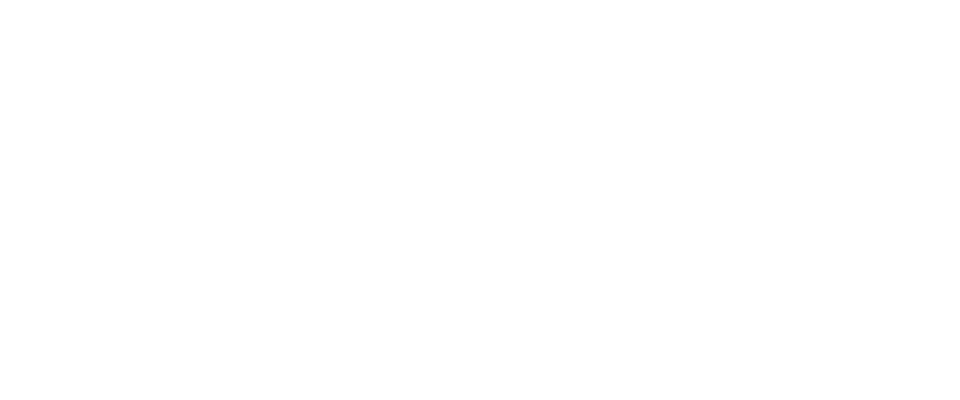

In [57]:

ax = sns.relplot(data=lin_dimensional_data[4], kind='line', x='buckets', y='score', height=height, aspect=aspect)
# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
#plt.xticks(
#    ticks=range(0, 101, 5), 
#    labels=[99] + [percentage for percentage in range(95, -1, -5)]
#)
plt.yticks(np.linspace(0.8, 1., 11))
plt.xlabel("Percentage % Corrupted")
#ax.set(title='Score vs Buckets Used')
plt.show()
#ax.figure.savefig('img_results/lin_percent.png', dpi=200)

### The last score is missing!!!

In [59]:
pd.DataFrame(lin_dimensional_data[4]).groupby('buckets').mean()

score  n_run  Dimension
buckets                            
1        0.900683   49.5        4.0
2        0.949583   49.5        4.0
3        0.963667   49.5        4.0
4        0.973967   49.5        4.0
5        0.978467   49.5        4.0
...           ...    ...        ...
95       0.998867   49.5        4.0
96       0.998867   49.5        4.0
97       0.998967   49.5        4.0
98       0.998900   49.5        4.0
99       0.998750   49.5        4.0

[99 rows x 3 columns]